In [250]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

In [5]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [6]:
class Neuron:
  def __init__(self, x=None, w=None, function=sigmoid):
    self.x = x
    self.u = None
    self.pd = None
    self.function = function
    
    if type(self.x) is float or type(self.x) is int:
      # Bias ou entrada
      self.w = None
      self.g = self.x
    elif type(self.x) is list:
      # Normal
      self.w = w if type(w) is np.ndarray else np.random.random(len(self.x))
      self.u = self.x @ self.w
      self.g = self.function(self.u)
    else:
      # Não-inicializado
      self.w = w if w is None or type(w) is np.ndarray else np.random.random(w)
      self.g = None
      
  def update(self, new_x):
      self.x = new_x
      if not self.is_bias():
        self.u = self.x @ self.w
        self.g = self.function(self.u)
      else:
        self.g = self.x
  
  is_bias = lambda self: True if self.w is None else False
  
  __repr__ = lambda self: '{} @ {} -> {}'.format(self.x, self.w, self.g)

In [317]:
class MLP:
  def __init__(self, topology):
    self.topology = topology
    
    self.init_neurons()
    
  def init_neurons(self):
    # Camada de entrada
    self.layers = [[Neuron() for i in range(self.topology[0])]]
    self.layers[0] += [Neuron(1)] # Bias 
    
    # Camadas ocultas e de saída
    for i in range(1, len(self.topology)):
      self.layers += [[Neuron(w=len(self.layers[i - 1])) for j in range(self.topology[i])]]
      if i != len(self.topology) - 1: self.layers[i] += [Neuron(1)] # Bias

  def update_neurons(self): 
    # Camada de entrada
    [self.layers[0][i].update(self.inputs[i]) for i in range(len(self.inputs))]
    
    # Camadas ocultas e de saída
    for i in range(1, len(self.layers)):
      [n.update([e.g for e in self.layers[i - 1]]) for n in self.layers[i] if not n.is_bias()]
        
  def update_weights(self):
    # Camada de saída
    for i in range(len(self.layers[-1])):
      # Derivada parcial
      neuron = self.layers[-1][i]
      neuron.pd = - (self.desired[i] - neuron.g) * neuron.g * (1 - neuron.g)
      # Pesos
      for j in range(len(neuron.w)):
        neuron.w[j] -= self.learning_rate * neuron.pd * self.layers[-2][j].g
          
    # Camadas ocultas
    for i in range(len(self.layers) - 2, 0, -1):
      for j in range(len(self.layers[i]) - 1):
        # Derivada parcial
        neuron = self.layers[i][j]
#         print(neuron)
        descendents = sum([n.pd * n.w[j] for n in self.layers[i + 1] if not n.is_bias()])
        neuron.pd = descendents * neuron.g * (1 - neuron.g)
        # Pesos
        for k in range(len(neuron.w)):
          neuron.w[k] -= self.learning_rate * neuron.pd * neuron.x[k]
  
  def update_errors(self):
    out_layer = self.layers[-1]
    out_length = len(out_layer)
    self.errors = [(out_layer[i].g - self.desired[i]) ** 2 for i in range(out_length)]
    self.total_error = sum(self.errors) / 2
    
  def train(self, train_data, learning_rate=.1, precision=10**-6):
    self.learning_rate = learning_rate
    self.precision = precision
    self.epochs = 0
    self.mean_square_error = [0]
    last_mse = 0
    
    while abs(self.mean_square_error[-1] - last_mse) > self.precision or self.epochs == 0:
      last_mse = self.mean_square_error[-1]
      
      errors_sum = 0
      for index, sample in train_data.iterrows():
        self.inputs = sample[:self.topology[0]].tolist()
        self.desired = sample[self.topology[0]:].tolist()
        self.update_neurons()

        self.update_errors()
        errors_sum += self.total_error

        self.update_weights()

      self.update_neurons()
      self.epochs += 1
      
      self.mean_square_error.append(errors_sum / train_data.shape[0])
    
    print('Treinamento concluído')
        
  def test_sample(self, sample):
    inputs, desired = sample[:self.topology[0]], sample[self.topology[0]:]
    layers = cp.deepcopy(self.layers)
    
    # Camada de entrada
    [layers[0][i].update(inputs[i]) for i in range(len(inputs))]
    
    # Camada de saída
    for i in range(1, len(layers)):
      [n.update([e.g for e in layers[i - 1]]) for n in layers[i] if not n.is_bias()]
      
    return [(layers[-1][i].g, desired[i], desired[i] - layers[-1][i].g) for i in range(len(layers[-1]))]
  
  def show_weights(self):
    output = ''
    for i in range(1, len(self.layers)):
      output += 'Camada {}\n'.format(i)
      for j in range(len(self.layers[i])):
        neuron = self.layers[i][j]
        if not neuron.is_bias():
          output += 'Neurônio {:2d}: {}\n'.format(j, neuron.w)
      output += '\n'
    
    return output

  def __repr__(self):
    result = 'Topologia: {}\t'.format(self.topology)
    result += 'Épocas: {}\n\n'.format(self.epochs)
    result += 'Pesos\n'
    result += self.show_weights()
    
    return result

In [491]:
df = pd.read_csv('../../datasets/ressonancia.csv')
df

,x1,x2,x3,d
0,0.8799,0.7998,0.3972,0.8399
1,0.5700,0.5111,0.2418,0.6258
2,0.6796,0.4117,0.3370,0.6622
3,0.3567,0.2967,0.6037,0.5969
4,0.3866,0.8390,0.0232,0.5316
...,...,...,...,...
195,0.0339,0.4669,0.1526,0.3250
196,0.0080,0.8988,0.4201,0.5404
197,0.9955,0.8897,0.6175,0.9360
198,0.7408,0.5351,0.2732,0.6949


### Questões

#### 1)

In [320]:
trainings = [MLP([3, 10, 1]) for i in range(5)]
for ann in trainings: ann.train(df)

Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído


#### 2)

In [321]:
questao1 = pd.DataFrame(
  [[t.mean_square_error[-1], t.epochs] for t in trainings],
  index = ['T{}'.format(i) for i in range(1, 6)],
  columns = ['Erro quadrático médio', 'Nº de épocas'])
questao1.sort_values('Nº de épocas', ascending=False)

,Erro quadrático médio,Nº de épocas
T1,0.000836,149
T2,0.000827,142
T4,0.000802,133
T3,0.000826,113
T5,0.000783,108


#### 3)

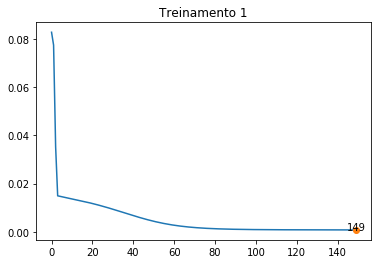

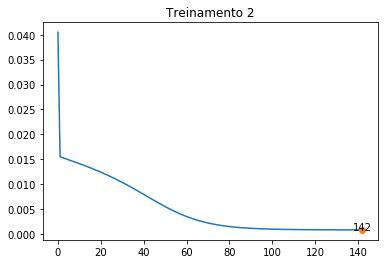

In [353]:
for i in [0, 1]:
  plt.title('Treinamento {}'.format(i + 1))
  
  plt.plot(range(trainings[i].epochs), trainings[i].mean_square_error[1:])
  
  plt.plot(trainings[i].epochs, trainings[i].mean_square_error[-1], 'o')
  plt.text(trainings[i].epochs,
           trainings[i].mean_square_error[-1],
           str(trainings[i].epochs),
           va='baseline', ha='center',)
    
  plt.show()

#### 4)

Devido a natureza estocástica do Perceptron de ajustar os pesos juntamente com a escolha randômica dos pesos iniciais

#### 5)

In [494]:
df2 = pd.read_csv('../../datasets/ressonancia2.csv')
df3 = pd.DataFrame([[t.test_sample(s)[0][0] for t in trainings] for s in df2.values],
                   columns=['y(T{})'.format(i) for i in range(1, 6)])
df4 = pd.concat([df2, df3], axis=1, sort=False)

df5 = pd.DataFrame(
  [[sum(abs(df4['d'] - df4['y(T{})'.format(i)]) / df4['d']) / 20 for i in range(1, 6)]],
  columns=['y(T{})'.format(i) for i in range(1, 6)])
df6 = pd.DataFrame(
  [[sum((df4['d'] - df4['y(T{})'.format(i)]) ** 2) / 19 for i in range(1, 6)]],
  columns=['y(T{})'.format(i) for i in range(1, 6)])
df7 = pd.concat([df4, df5, df6], sort=False)

df7.index = list(range(1, 21)) + ['Erro médio', 'Variância']
df7.fillna('', inplace=True)
df7

,x1,x2,x3,d,y(T1),y(T2),y(T3),y(T4),y(T5)
1,0.0611,0.286,0.7464,0.4831,0.479105,0.485074,0.484681,0.486692,0.486163
2,0.5102,0.7464,0.086,0.5965,0.588542,0.594533,0.593030,0.594437,0.593203
3,0.0004,0.6916,0.5006,0.5318,0.519671,0.528124,0.527587,0.530025,0.528133
4,0.943,0.4476,0.2648,0.6843,0.706653,0.708710,0.706028,0.707111,0.706251
5,0.1399,0.161,0.2477,0.2872,0.291091,0.278833,0.279941,0.277356,0.280079
6,0.6423,0.3229,0.8567,0.7663,0.752727,0.752976,0.753595,0.752468,0.751724
7,0.6492,0.0007,0.6422,0.5666,0.563814,0.570318,0.571302,0.571921,0.570014
8,0.1818,0.5078,0.9046,0.6601,0.677867,0.680999,0.681634,0.680194,0.679318
9,0.7382,0.2647,0.1916,0.5427,0.527078,0.534017,0.533926,0.535193,0.533443
10,0.3879,0.1307,0.8656,0.5836,0.598117,0.604363,0.605636,0.605388,0.604297


#### 6)

T(5), pois apresenta a melhor combinação entre o menor erro relativo médio e variância